In [1]:
### XGBoost implementation with cross-validation

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error

# Load data
start_time = time.time()
data = pd.read_csv('csv back/ind_output_3D_v4.csv')

# Define features (X) and target (Y)
X = data.iloc[:, :11]           # Observed variables
X = X.drop('npz', axis=1)       
Y = data.iloc[:, -1]            # Response variable (keff)

# Split the data into training and testing sets (log transofrmation on Y)
X_train, X_test, Y_train_log, Y_test_log = train_test_split(X, np.log10(Y), test_size=0.2, random_state=45)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data into DMatrix (XGBoost optimized data structure)
dtrain = xgb.DMatrix(X_train, label=Y_train_log)
dtest = xgb.DMatrix(X_test, label=Y_test_log)

# Parameters tuning
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'eval_metric': 'rmse',
    'colsample_bytree': 0.863,
    'learing_rate': 0.001,
    'max_depth': 8,
    'subsample': 0.614,
    'reg_alpha': 0.324,
    'reg_lambda': 0.122,
    'min_sample_loss': 0.05
    #'tree_method': 'gpu_hist',    # Use GPU for training
    #'predictor': 'gpu_predictor'  # Use GPU for prediction
}

# Perform cross-validation using xgb.cv
cv_results = xgb.cv(
    dtrain = dtrain,
    params = params,
    nfold = 5,                      # number of cross-validation folds
    num_boost_round = 2500,         # maximum boosting rounds
    early_stopping_rounds = 100,     # stop if no improvement after 50 rounds
    metrics = 'rmse',
    as_pandas = True,               # return results as Pandas DataFrame
    seed = 36,
    verbose_eval = True
)

# Get the optimal number of boosting rounds based on cross-validation results
best_num_boost_rounds = cv_results['test-rmse-mean'].idxmin()
print(f'Optimal number of boosting rounds: {best_num_boost_rounds}')

# Train final model using optimal number of rounds
xgb_regressor = xgb.train(
    params = params,
    dtrain = dtrain,
    num_boost_round = best_num_boost_rounds
)

end_time = time.time()

# Save the trained model to a json file
model_filename = 'model_xgbCV.json.json'
xgb_regressor.save_model(model_filename)
print(f'Model saved to {model_filename}')

# Predict on test and train data
Y_pred_log_test = xgb_regressor.predict(dtest)
Y_pred_log_train = xgb_regressor.predict(dtrain)

# Return predictions to the original scale and retrieve regression results
Y_pred_test = 10**(Y_pred_log_test)
Y_pred_train = 10**(Y_pred_log_train)
Y_train = 10**(Y_train_log)
Y_test = 10**(Y_test_log)

# Define custom evaluation function: mean relative squared error (mrse)
def mean_relative_squared_error(Y_true, Y_pred):
    return np.mean(((Y_true - Y_pred) / Y_true) ** 2)

# Evaluate the model
r2_xgb = r2_score(Y_test, Y_pred_test)
mse_xgb = mean_squared_error(Y_test, Y_pred_test)
mae_xgb = mean_absolute_error(Y_test, Y_pred_test)
mlsr_xgb = mean_squared_log_error(Y_test, Y_pred_test)
mrse_xgb = mean_relative_squared_error(Y_test, Y_pred_test)
running_time = end_time - start_time

# Create a dataframe with the evaluation metrics.
eval_metrics_xgbCV = {
    'Eval_metrics': ['R2 Score', 
                     'Mean squared error',
                     'Mean absolute error', 
                     'Mean squared log error', 
                     'Mean relative squared error',
                     'Training time (s)'],
    'XGBoost CV': [r2_xgb, 
                mse_xgb, 
                mae_xgb, 
                mlsr_xgb, 
                mrse_xgb,
                running_time]
}

df_metrics_xgbCV = pd.DataFrame(eval_metrics_xgbCV)
df_metrics_xgbCV.to_csv('metrics_xgbCV.csv', index=False)
print(df_metrics_xgbCV)

[0]	train-rmse:0.69789+0.00060	test-rmse:0.69802+0.00234


/home/chris/venv/cdd/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:41:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "learing_rate", "min_sample_loss" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	train-rmse:0.51849+0.00032	test-rmse:0.51940+0.00167
[2]	train-rmse:0.37874+0.00017	test-rmse:0.37992+0.00127
[3]	train-rmse:0.28573+0.00024	test-rmse:0.28725+0.00089
[4]	train-rmse:0.23505+0.00025	test-rmse:0.23755+0.00079
[5]	train-rmse:0.19447+0.00029	test-rmse:0.19739+0.00076
[6]	train-rmse:0.17024+0.00036	test-rmse:0.17362+0.00077
[7]	train-rmse:0.15676+0.00033	test-rmse:0.16055+0.00075
[8]	train-rmse:0.14903+0.00037	test-rmse:0.15321+0.00071
[9]	train-rmse:0.14483+0.00041	test-rmse:0.14938+0.00068
[10]	train-rmse:0.14251+0.00037	test-rmse:0.14762+0.00064
[11]	train-rmse:0.14072+0.00033	test-rmse:0.14612+0.00067
[12]	train-rmse:0.13934+0.00039	test-rmse:0.14512+0.00063
[13]	train-rmse:0.13843+0.00030	test-rmse:0.14448+0.00063
[14]	train-rmse:0.13768+0.00036	test-rmse:0.14398+0.00061
[15]	train-rmse:0.13703+0.00026	test-rmse:0.14365+0.00069
[16]	train-rmse:0.13651+0.00027	test-rmse:0.14339+0.00072
[17]	train-rmse:0.13607+0.00030	test-rmse:0.14320+0.00071
[18]	train-rmse:0.13560

/home/chris/venv/cdd/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:41:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "learing_rate", "min_sample_loss" } are not used.

  warnings.warn(smsg, UserWarning)


Model saved to model_xgbCV.json.json
                  Eval_metrics  XGBoost CV
0                     R2 Score    0.951647
1           Mean squared error    3.660255
2          Mean absolute error    1.198866
3       Mean squared log error    0.047224
4  Mean relative squared error    0.316582
5            Training time (s)    9.751194


<Figure size 2500x400 with 0 Axes>

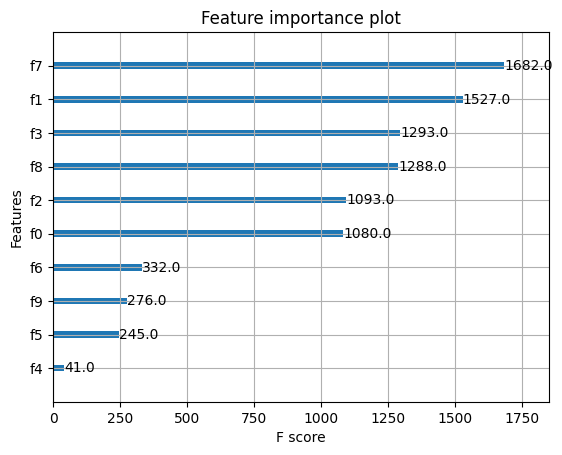

Feature 0: PPHA
Feature 1: VOLALE
Feature 2: ZNCC
Feature 3: GAMMA
Feature 4: spanning
Feature 5: npy
Feature 6: npx
Feature 7: Plen
Feature 8: S
Feature 9: P


In [2]:
### XGBoost plots
# Plot fearures importance

plt.figure(figsize=(25, 4))
xgb.plot_importance(xgb_regressor, max_num_features=10)
plt.title('Feature importance plot')
plt.show()
feature_names = X.columns
for i, feature in enumerate(feature_names):
    print(f"Feature {i}: {feature}")

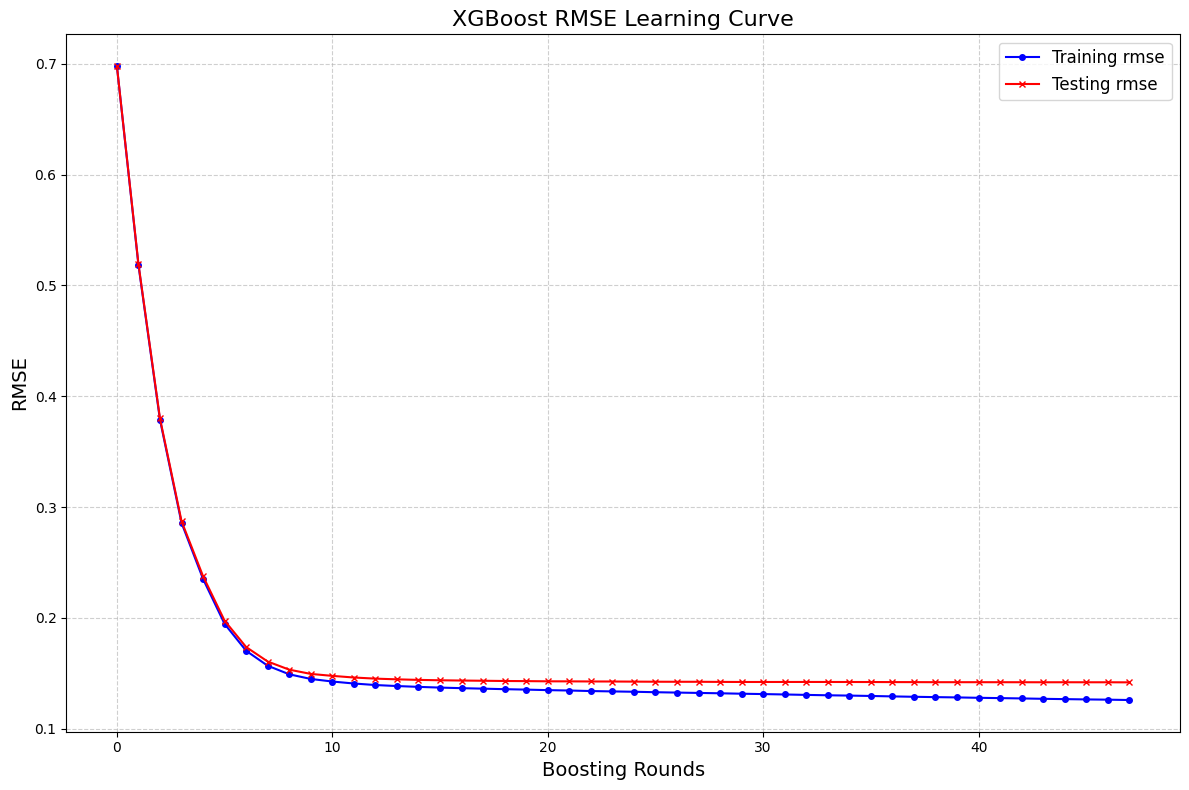

In [3]:
### XGBoost plots
'''
RMSE learning curves plot: Tracking the training progress of the model by plotting the learning 
curves, which show how the RMSE changes as more rounds of boosting are performed.
'''

epochs = len(cv_results['train-rmse-mean'])
x_axis = range(epochs)
plt.figure(figsize=(12, 8))
plt.plot(x_axis, cv_results['train-rmse-mean'], label='Training rmse', color='b', marker='o', markersize=4)
plt.plot(x_axis, cv_results['test-rmse-mean'], label='Testing rmse', color='r', marker='x', markersize=4)
plt.title('XGBoost RMSE Learning Curve', fontsize=16)
plt.xlabel('Boosting Rounds', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.grid(visible=True, which='both', linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

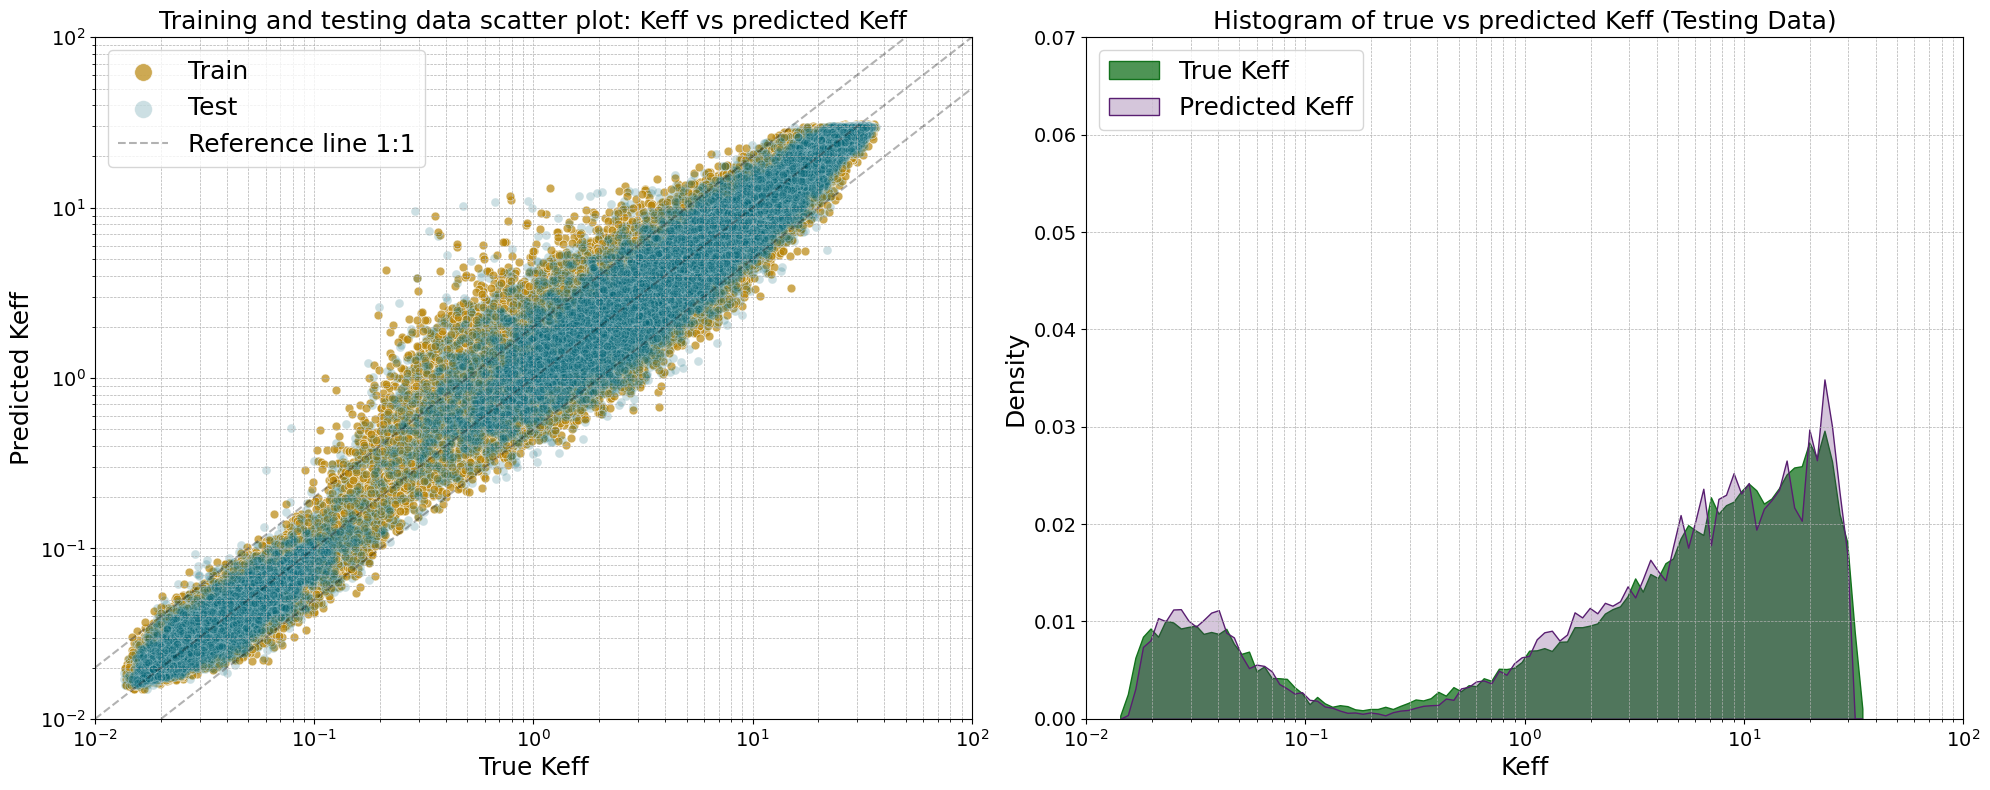

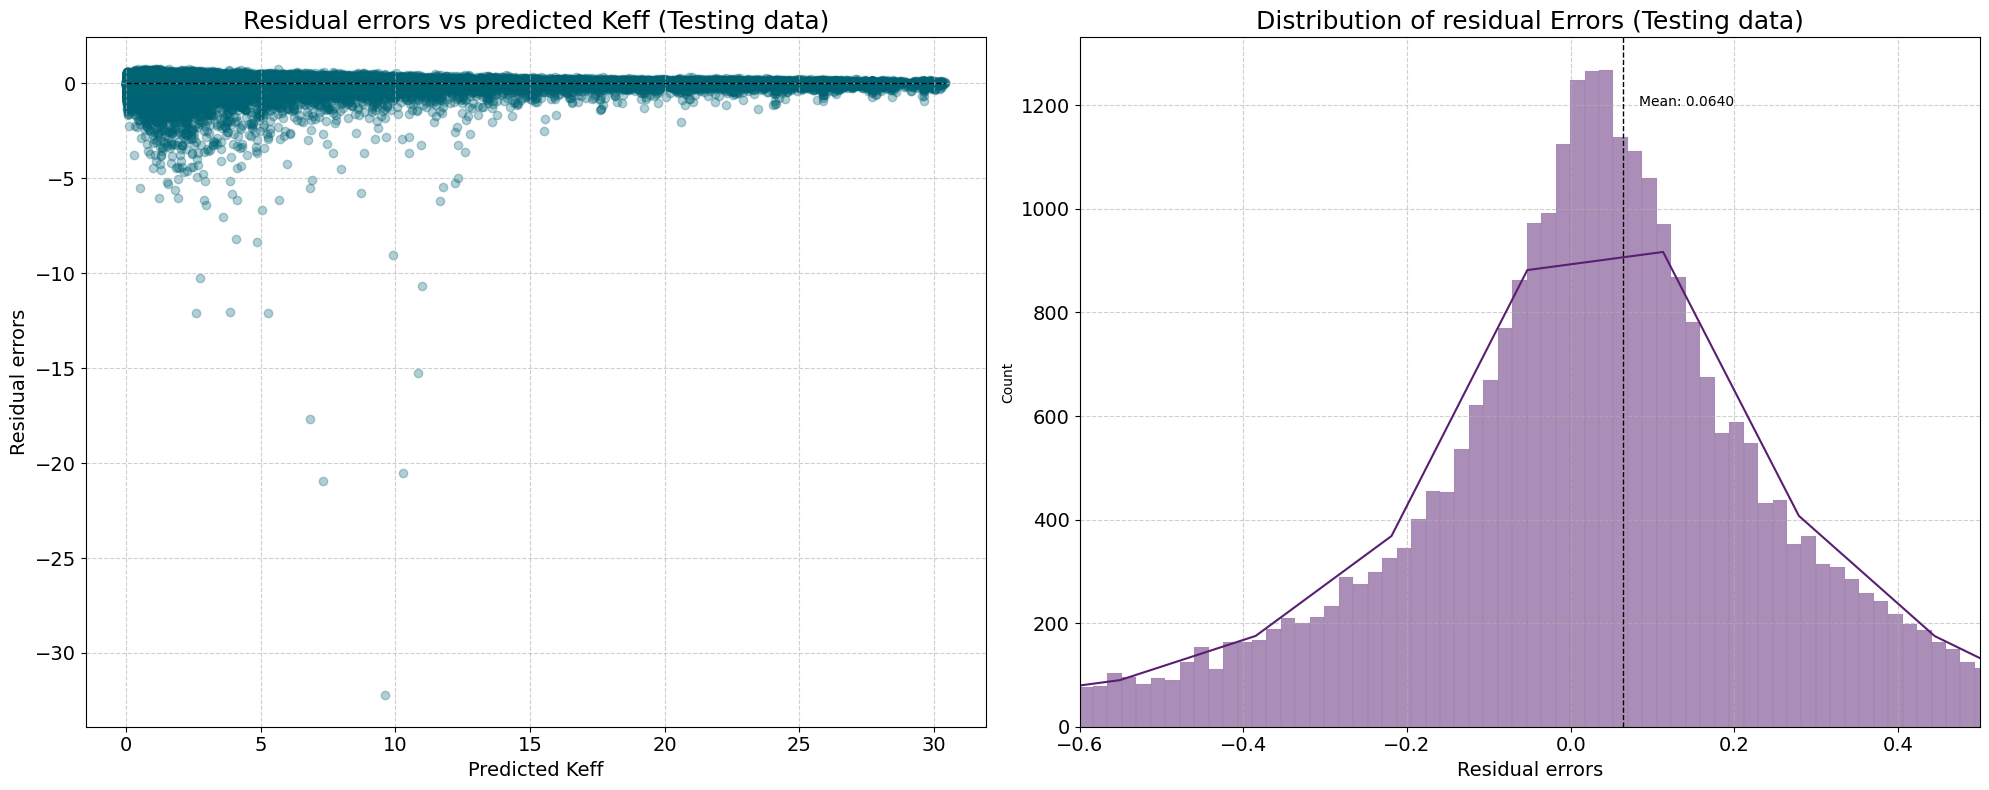

In [4]:
### XGBoost plots
# Filter data

data_plot_train = pd.DataFrame(Y_train)
data_plot_train['Y_pred_train'] = Y_pred_train
data_plot_train_rel = ((data_plot_train['keff']-data_plot_train['Y_pred_train'])/data_plot_train['keff'])

data_plot_test = pd.DataFrame(Y_test)
data_plot_test['Y_pred_test'] = Y_pred_test
data_plot_test_rel = ((data_plot_test['keff']-data_plot_test['Y_pred_test'])/data_plot_test['keff'])

# Scatter plot for Train data
palette = sns.color_palette('dark')
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='keff', 
    y='Y_pred_train',
    data=data_plot_train,
    label='Train', 
    color=palette[8], 
    s=40,  
    alpha=0.70)

sns.scatterplot(
    x='keff', 
    y='Y_pred_test', 
    data=data_plot_test,
    label='Test', 
    color=palette[9], 
    s=40,  
    alpha=0.20)

plt.loglog([1E-2, 1E2], [1E-2, 1E2], c='k', alpha=0.3, linestyle='--', label='Reference line 1:1')
plt.loglog([1E-2, 0.5E2], [2E-2, 1E2], c='k', alpha=0.3, linestyle='--')
plt.loglog([2E-2, 1E2], [1E-2, 0.5E2], c='k', alpha=0.3, linestyle='--')

plt.legend(loc='upper left', fontsize=18, markerscale=2)
plt.xlim([1E-2, 1E2])
plt.ylim([1E-2, 1E2])
plt.xlabel('True Keff', fontsize=18)
plt.ylabel('Predicted Keff', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Training and testing data scatter plot: Keff vs predicted Keff', fontsize=18)

# Histogram for Testing data
plt.subplot(1, 2, 2)

logMin, logMax = np.log10(data_plot_train['keff'].min()), np.log10(data_plot_train['keff'].max())
newBins = np.logspace(logMin, logMax, 100)

sns.histplot(
    data_plot_test['keff'], 
    bins=newBins, 
    kde=False, 
    color=palette[2],
    stat="probability", 
    element='poly', 
    label='True Keff', 
    alpha=0.75)

sns.histplot(
    data_plot_test['Y_pred_test'], 
    bins=newBins, 
    kde=False, 
    color=palette[4], 
    stat="probability", 
    element='poly', 
    label='Predicted Keff', 
    alpha=0.25)

plt.legend(loc='upper left', fontsize=18)
plt.xlim([1E-2, 1E2])
plt.ylim([0, 0.07])
plt.xscale('log')
plt.ylabel("Density", fontsize=18)
plt.xlabel('Keff', fontsize=18)
plt.title('Histogram of true vs predicted Keff (Testing Data)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Residuals error plot
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
residuals = (Y_test - Y_pred_test) / Y_test
plt.scatter(Y_pred_test, residuals, alpha=0.3, color=palette[9])
plt.hlines(y=0, xmin=Y_pred_test.min(), xmax=Y_pred_test.max(), colors='k', linestyles='--', linewidth=1)
plt.xlabel('Predicted Keff', fontsize=14)
plt.ylabel('Residual errors', fontsize=14)
plt.title('Residual errors vs predicted Keff (Testing data)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Error distribution plot
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color=palette[4], alpha=0.5)
plt.xlabel('Residual errors', fontsize=14)
plt.xlim(-0.6, 0.5)
plt.title('Distribution of residual Errors (Testing data)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

mean_residual = abs(residuals.mean())
plt.axvline(mean_residual, color='k', linestyle='--', linewidth=1)
plt.text(mean_residual + 0.02, plt.ylim()[1] * 0.9, f'Mean: {mean_residual:.4f}', color='k')
plt.tight_layout()
plt.show()

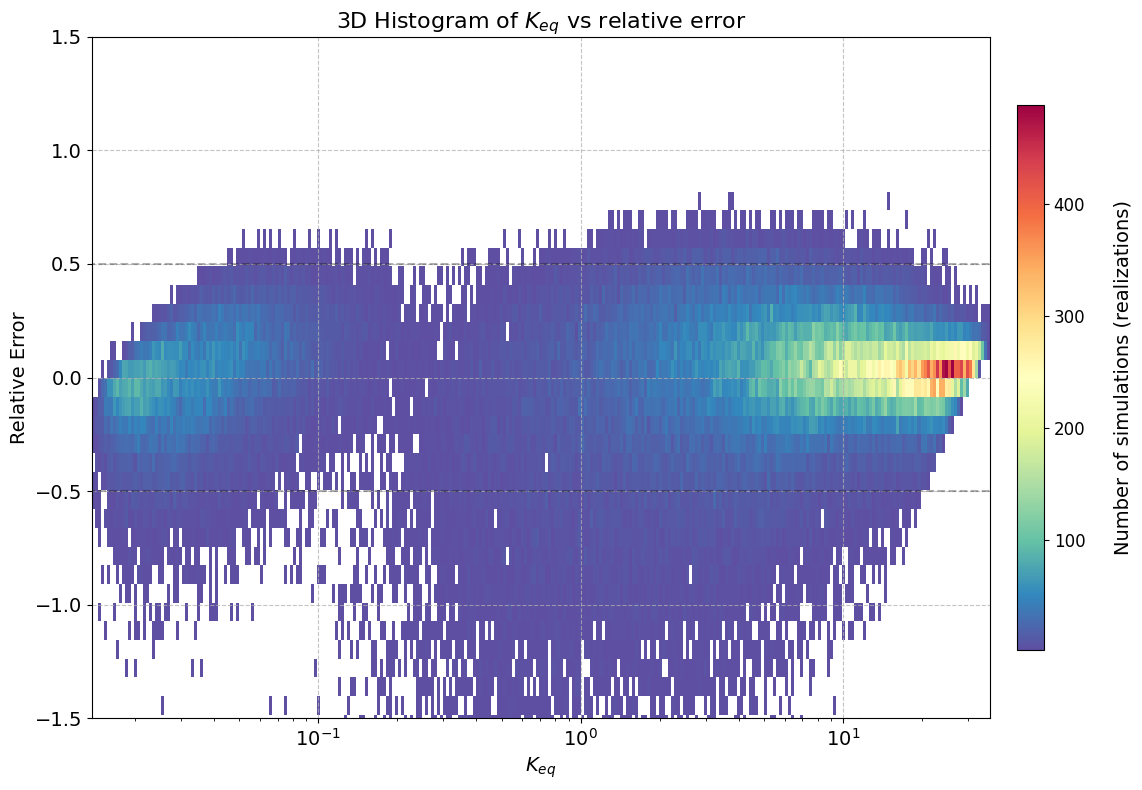

In [5]:
# 3D Histogram (Keff vs. Relative error)
plt.figure(figsize=(12, 8))
x = data_plot_train['keff']
y = data_plot_train_rel
LogMin, LogMax = np.log10(data_plot_train['keff'].min()), np.log10(data_plot_train['keff'].max())
newBins = np.logspace(LogMin, LogMax, 300)
hist2d = plt.hist2d(x, y, bins=[newBins, 300], cmap=plt.cm.Spectral_r, cmin=1)
cbar = plt.colorbar(pad=0.025, shrink=0.8)#.ax.set_yscale('log')
cbar.set_label(label='Number of simulations (realizations)', fontsize=14, labelpad=20)
cbar.ax.tick_params(labelsize=12)
plt.plot([1E-3, 1E2], [0.5, 0.5], c='k', alpha=0.3, linestyle='--')
plt.plot([1E-3, 1E2], [-0.5, -0.5], c='k', alpha=0.3, linestyle='--')
plt.xscale('log')
plt.xlabel(r'$K_{eq}$',  fontsize=14)
plt.ylim([-1.5, 1.5])
plt.ylabel('Relative Error', fontsize=14)
plt.title('3D Histogram of '+r'$K_{eq}$'+' vs relative error', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.75)
plt.tight_layout()
plt.show()

In [6]:
### XGBoost implementation with RandomizedSearchCV for faster hyperparametr tuning
'''
Unlike GridSearchCV, which tries all possible combiationn of hyperparameters,
RandomizedSearchCV samples a fixed number of hyperparameters combinations from
the specified space. This is useful when you have a large hyprparameteres space,
as it saves time by exploring only a subset of all possible combinations.
'''

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from scipy.stats import uniform, randint

start_time_RS = time.time()

data = pd.read_csv('csv back/ind_output_3D_v3.csv')

X = data.iloc[:, :11]
X = X.drop('npz', axis=1)
Y = data.iloc[:, -1]

X_train_xgb_rs, X_test_xgb_rs, Y_train_log_xgb_rs, Y_test_log_xgb_rs = train_test_split(X, np.log(Y), test_size=0.2, random_state=45)

scaler = StandardScaler()
X_train_xgb_rs = scaler.fit_transform(X_train_xgb_rs)
X_test_xgb_rs = scaler.transform(X_test_xgb_rs)

# Define the XGBoost regressor 
xgb_regressor = xgb.XGBRegressor() # (tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False)   # Use GPU for training

# Define the space of hyperparameters
param_distributions = {
    'colsample_bytree': uniform(0.3, 0.7),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 1000),
    'subsample': uniform(0.4, 0.6),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Define scoring functions
scorers = {
    'r2': make_scorer(r2_score),
    'neg_mse': make_scorer(mean_squared_error, greater_is_better=False)
}

# RandomizedSearchCV with cross-validation to optimize hyperparameter tuning
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_distributions,
    scoring=scorers,
    refit='r2',         # Refit the model using R² after searching
    cv=4,               # 4-fold cross-validation
    n_iter=25,          # Number of random combinations to try
    verbose=1,
    random_state=42,
    n_jobs=-1           # -1 to use all processors avalaible
)

# Fit the RSCV to find the best parameters
random_search_xgb.fit(X_train_xgb_rs, Y_train_log_xgb_rs)

# Get the best parameters
best_params = random_search_xgb.best_params_
print(f'Best hyperparameters: {best_params}')

params_filename = 'best_params_xgbRS.json'
with open(params_filename, 'w') as params_file:
    json.dump(best_params, params_file)
print(f'Best hyperparameters saved to: {params_filename}')

# Instantiate and train the XGBoost regressor with the best hyperparameters 
xgb_regressor = xgb.XGBRegressor(**best_params, eval_metrics='rmse', early_stopping_rounds=500) #, tree_method='gpu_hist', predictor='gpu_predictor',)  ## Use GPU for training
xgb_model = xgb_regressor.fit(X_train_xgb_rs, Y_train_log_xgb_rs, verbose=True, eval_set = [(X_train_xgb_rs, Y_train_log_xgb_rs), (X_test_xgb_rs, Y_test_log_xgb_rs)])

end_time_RS = time.time()

# Save the trained XGBoost model to a file
model_filename = 'model_xgbRS.json'
xgb_model.save_model(model_filename)
print(f'Model saved to {model_filename}')

# Predict on test data
Y_pred_log_test_xgb_rs = xgb_model.predict(X_test_xgb_rs)
Y_pred_log_train_xgb_rs = xgb_model.predict(X_train_xgb_rs)

# Return predictions to the original scale
Y_pred_test_xgb_rs = np.exp(Y_pred_log_test_xgb_rs)
Y_pred_train_xgb_rs = np.exp(Y_pred_log_train_xgb_rs)
Y_train_xgb_rs = np.exp(Y_train_log_xgb_rs)
Y_test_xgb_rs = np.exp(Y_test_log_xgb_rs)

# Evaluate the model
# Define custom evaluation function: Mean Relative Squared Error (MRSE)
def mean_relative_squared_error(Y_true, Y_pred):
    return np.mean(((Y_true - Y_pred) / Y_true) ** 2)

r2_xgb_rs = r2_score(Y_test_xgb_rs, Y_pred_test_xgb_rs)
mse_xgb_rs = mean_squared_error(Y_test_xgb_rs, Y_pred_test_xgb_rs)
mae_xgb_rs = mean_absolute_error(Y_test_xgb_rs, Y_pred_test_xgb_rs)
mslr_xgb_rs = mean_squared_log_error(Y_test_xgb_rs, Y_pred_test_xgb_rs)
mrse_xgb_rs = mean_relative_squared_error(Y_test_xgb_rs, Y_pred_test_xgb_rs)
running_time_xgbRS = end_time_RS - start_time_RS

# Create a dataframe with the evaluation metrics.
eval_metrics_xgbRS = {
    'Eval_metrics': ['R2 Score', 
                     'Mean Squared Error',
                     'Mean Absolute Error',  
                     'Mean Squared Log Error',
                     'Mean Relative Squeared Error', 
                     'Training time (s)'],

    'XGBoost RS': [r2_xgb_rs, 
                   mse_xgb_rs,
                   mae_xgb_rs,  
                   mslr_xgb_rs, 
                   mrse_xgb_rs,
                   running_time_xgbRS]
}

df_metrics_xgbRS = pd.DataFrame(eval_metrics_xgbRS)
df_metrics_xgbRS.to_csv('metrics_xgbRS.csv', index=False)
print(df_metrics_xgbRS)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best hyperparameters: {'colsample_bytree': 0.8615378865278278, 'learning_rate': 0.032365193103931246, 'max_depth': 9, 'n_estimators': 620, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 0.1987156815341724, 'subsample': 0.4033132702741615}
Best hyperparameters saved to: best_params_xgbRS.json
[0]	validation_0-rmse:2.11823	validation_1-rmse:2.13689
[1]	validation_0-rmse:2.05513	validation_1-rmse:2.07345
[2]	validation_0-rmse:1.99037	validation_1-rmse:2.00825
[3]	validation_0-rmse:1.92780	validation_1-rmse:1.94520
[4]	validation_0-rmse:1.87078	validation_1-rmse:1.88782
[5]	validation_0-rmse:1.81214	validation_1-rmse:1.82878
[6]	validation_0-rmse:1.75549	validation_1-rmse:1.77175
[7]	validation_0-rmse:1.70074	validation_1-rmse:1.71664
[8]	validation_0-rmse:1.64774	validation_1-rmse:1.66328
[9]	validation_0-rmse:1.59658	validation_1-rmse:1.61177
[10]	validation_0-rmse:1.55013	validation_1-rmse:1.56514
[11]	validation_0-rmse:1.502

/home/chris/venv/cdd/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:45:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:1.45677	validation_1-rmse:1.47106
[13]	validation_0-rmse:1.41287	validation_1-rmse:1.42686
[14]	validation_0-rmse:1.36958	validation_1-rmse:1.38326
[15]	validation_0-rmse:1.32775	validation_1-rmse:1.34116
[16]	validation_0-rmse:1.28734	validation_1-rmse:1.30051
[17]	validation_0-rmse:1.24825	validation_1-rmse:1.26118
[18]	validation_0-rmse:1.21048	validation_1-rmse:1.22314
[19]	validation_0-rmse:1.17396	validation_1-rmse:1.18640
[20]	validation_0-rmse:1.13935	validation_1-rmse:1.15157
[21]	validation_0-rmse:1.10533	validation_1-rmse:1.11729
[22]	validation_0-rmse:1.07247	validation_1-rmse:1.08425
[23]	validation_0-rmse:1.04082	validation_1-rmse:1.05239
[24]	validation_0-rmse:1.01030	validation_1-rmse:1.02166
[25]	validation_0-rmse:0.98258	validation_1-rmse:0.99382
[26]	validation_0-rmse:0.95395	validation_1-rmse:0.96502
[27]	validation_0-rmse:0.92639	validation_1-rmse:0.93726
[28]	validation_0-rmse:0.89983	validation_1-rmse:0.91055
[29]	validation_0-rmse:0.87475	